<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/resnet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d erhmrai/ecg-image-data

 98% 841M/858M [00:09<00:00, 126MB/s]
100% 858M/858M [00:09<00:00, 92.0MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-image-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report

(288, 432, 4)


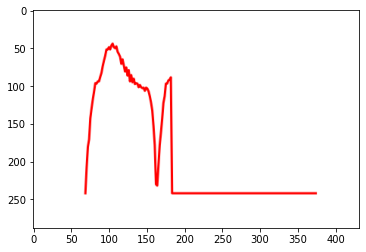

In [5]:
import cv2
path =r'/content/ECG_Image_data/test/S/S1070.png'
x=plt.imread(path)
print(x.shape)
plt.imshow(x)

In [6]:
train_dir = Path('/content/ECG_Image_data/train')

filepaths = list(train_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/Q/Q1039.png,Q
1,/content/ECG_Image_data/train/Q/Q7206.png,Q
2,/content/ECG_Image_data/train/Q/Q367.png,Q
3,/content/ECG_Image_data/train/Q/Q4548.png,Q
4,/content/ECG_Image_data/train/Q/Q6629.png,Q
...,...,...
99194,/content/ECG_Image_data/train/M/M2469.png,M
99195,/content/ECG_Image_data/train/M/M5724.png,M
99196,/content/ECG_Image_data/train/M/M8708.png,M
99197,/content/ECG_Image_data/train/M/M9175.png,M


In [7]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [8]:
samples = []
for category in dataframe['Label'].unique():
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

Q    640
S    640
N    640
M    640
F    640
V    640
Name: Label, dtype: int64

In [9]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/Q/Q6407.png,Q
1,/content/ECG_Image_data/train/S/S1238.png,S
2,/content/ECG_Image_data/train/N/N10626.png,N
3,/content/ECG_Image_data/train/N/N92838.png,N
4,/content/ECG_Image_data/train/M/M8289.png,M
...,...,...
3835,/content/ECG_Image_data/train/N/N4068.png,N
3836,/content/ECG_Image_data/train/F/F40.png,F
3837,/content/ECG_Image_data/train/F/F799.png,F
3838,/content/ECG_Image_data/train/Q/Q2081.png,Q


In [10]:
test_dir = Path('/content/ECG_Image_data/test')

filepaths = list(test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/Q/Q2513.png,Q
1,/content/ECG_Image_data/test/Q/Q5854.png,Q
2,/content/ECG_Image_data/test/Q/Q7493.png,Q
3,/content/ECG_Image_data/test/Q/Q3968.png,Q
4,/content/ECG_Image_data/test/Q/Q2804.png,Q
...,...,...
24794,/content/ECG_Image_data/test/M/M1245.png,M
24795,/content/ECG_Image_data/test/M/M935.png,M
24796,/content/ECG_Image_data/test/M/M646.png,M
24797,/content/ECG_Image_data/test/M/M400.png,M


In [11]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [12]:
samples = []
for category in dataframe_test['Label'].unique():
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

F    160
M    160
S    160
Q    160
V    160
N    160
Name: Label, dtype: int64

In [13]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/F/F309.png,F
1,/content/ECG_Image_data/test/M/M1867.png,M
2,/content/ECG_Image_data/test/S/S1423.png,S
3,/content/ECG_Image_data/test/S/S1021.png,S
4,/content/ECG_Image_data/test/S/S2257.png,S
...,...,...
955,/content/ECG_Image_data/test/N/N26117.png,N
956,/content/ECG_Image_data/test/Q/Q119.png,Q
957,/content/ECG_Image_data/test/M/M1906.png,M
958,/content/ECG_Image_data/test/F/F184.png,F


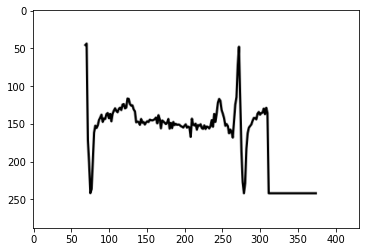

In [14]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [15]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [16]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                   shear_range = 0.2,
                   horizontal_flip=True,
                   zoom_range = 0.2,
                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale= 1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        subset='training',
        class_mode= "categorical")
val_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        subset='validation',
        class_mode= "categorical")
test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical")

Found 79362 images belonging to 6 classes.
Found 19837 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.


In [18]:
for data_batch, labels_batch in train_generator:
    print("data_batch shape --> ",data_batch.shape)
    print("labels_batch shape --> ",labels_batch.shape)
    break

data_batch shape -->  (32, 224, 224, 3)
labels_batch shape -->  (32, 6)


In [19]:
test_generator.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

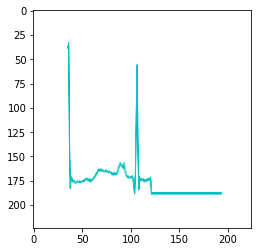

In [20]:
plt.imshow(test_generator[0][0][3])

In [21]:
IMAGE_SIZE = [224, 224]


resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3], 
    weights = 'imagenet', 
    include_top = False  
)

94765736/94765736 [==============================] - 0s 0us/step


In [22]:
for layer in resnet.layers:
    layer.trainable = False

In [23]:
folders = glob('/content/ECG_Image_data/train/*')
folders

['/content/ECG_Image_data/train/Q',
 '/content/ECG_Image_data/train/F',
 '/content/ECG_Image_data/train/S',
 '/content/ECG_Image_data/train/V',
 '/content/ECG_Image_data/train/N',
 '/content/ECG_Image_data/train/M']

In [24]:
x = Flatten() (resnet.output)

In [25]:
prediction = Dense(len(folders), activation='softmax')(x)

In [26]:
model = Model(inputs=resnet.input, outputs=prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [27]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
history = model.fit_generator(
  train_generator,
  validation_data=val_generator,
  epochs=10,
  steps_per_epoch=train_generator.samples//32, #len(train_generator)
  validation_steps=val_generator.samples//32, #len(val_generator)
  callbacks=[checkpoint]
)

<ipython-input-29-ed6f95ef0ab9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
2480/2480 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9577
Epoch 1: val_accuracy improved from -inf to 0.96683, saving model to best_model.h5
2480/2480 [==============================] - 1243s 497ms/step - loss: 0.2437 - accuracy: 0.9577 - val_loss: 0.1610 - val_accuracy: 0.9668
Epoch 2/10
2480/2480 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9745
Epoch 2: val_accuracy improved from 0.96683 to 0.98602, saving model to best_model.h5
2480/2480 [==============================] - 1213s 489ms/step - loss: 0.1881 - accuracy: 0.9745 - val_loss: 0.0834 - val_accuracy: 0.9860
Epoch 3/10
2480/2480 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9812
Epoch 3: val_accuracy did not improve from 0.98602
2480/2480 [==============================] - 1207s 487ms/step - loss: 0.1526 - accuracy: 0.9812 - val_loss: 0.1073 - val_accuracy: 0.9829
Epoch 4/10
2480/2480 [==============================] - ETA: 0s - loss: 

In [30]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.15730
Test Accuracy: 98.27%


In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

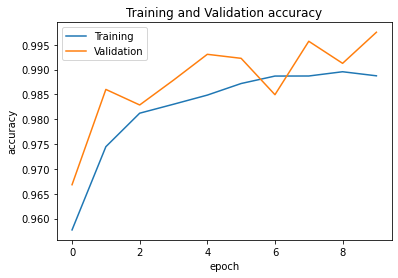

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')